In [19]:
# June 2021
# Original 2d lattice verion by Eric Corwin, University of Oregon
# Remade by Elyse Smolkowski to become structure and dimension agnostic using by graphs.
# This program provides a basic monte carlo ising model simulation in an arbitrary lattice pattern in any dimension.
# Included are several constructors to create 2d,3d, and 4d square lattice patterns, but theoretically any structure is possible.
# One caveat of the way this script is programmed is that it does not account for the distance between neighbors.
# At some point in the future I would like to account for distances, add better visualizations, and remake the script in C++

import numpy as np
from matplotlib import pyplot as plt
import time

In [37]:
class State:
    """
        This class holds all the information about a given state and provides useful
        methods to interact with the nodes stored inside.
    """
    def __init__(self, J=1, mu=1, B=0):
        # flat array with all the nodes
        # individual neighbors will be stored in the nodes themselves
        self.state = []
        self.J = J
        self.mu = mu
        self.B = B
    
    def new_node(self,spin=None):
        """
        Creates a new node, and adds it to the state.
        args:
            spin: If nothing entered, it will be random
        returns:
            Node: The node to be returned
        """
        index = len(self.state)
        node = Node(self,index,spin)
        self.state.append(node)
        return node
        
    def get_random(self):
        """
        Fetches a random node in the state.
        args:
            None
        returns:
            Node: The node to be returned
        """
        idx = np.random.randint(len(self.state))
        return self.state[idx]
    
    def calc_total_energy(self):
        """
        Calculates the total energy in the presence of an external field B with the equation
        E = -J (Sum_neighbors s_i*s_j) - mu * B * (Sum s_i)
        args:
            None
        returns:
            Energy: The energy of the state
        """
        J = self.get_J()
        mu = self.get_mu()
        B = self.get_B()
        Energy = 0
        
        # Compute the interaction term with the node's neighbors
        # There are probably better ways of doing this part.
        burnt_pairs = []
        for node in self.state:
            Energy += -mu*B*node.get_spin()
            for neighbor in node.get_neighbors():
                if (node.get_index(),neighbor.get_index()) not in burnt_pairs:
                    #print("unburnt pair", (node.get_index(),neighbor.get_index()))
                    Energy += -J * node.get_spin() * neighbor.get_spin()
                    burnt_pairs.append((node.get_index(),neighbor.get_index()))
                    burnt_pairs.append((neighbor.get_index(),node.get_index()))
                #else:
                    #print("burnt pair",(node.get_index(),neighbor.get_index()))
        return Energy
    
    def calc_magnetization(self):
        M = 0
        for node in self.state:
            M += node.get_spin()
        return M
            
    def get_size(self):
        return len(self.state)
    
    def get_J(self):
        return self.J
    def get_mu(self):
        return self.mu
    def get_B(self):
        return self.B

class Node:
    """
        The individual graph nodes inside of the state. They can be arranged in any
        type of configuration, from 2d square lattices to 3d diamond crystal patterns to n dimensional shapes.
    """
    def __init__(self,state,index,spin=None):
        # only to be called from State.add_node()
        
        # mark down what state this node is in
        self.state = state
        
        # mark down what index this node is
        self.index = index
        
        # generate random spin
        self.spin = np.random.choice([-1, 1])
        
        # but if spin was given in arguments, set spin as that instead
        if (spin != None):
            self.spin = spin
        
        # initialize neighbor array
        self.neighbors = []
        
        # store a dictionary that holds arbitrary data
        self.data = {}
    
    def add_neighbor(self,neighbor):
        """
            Adds a node to this node's neighbor list.
            args:
                neighbor: the node to be added.
        """
        self.neighbors.append(neighbor)
        
    def get_neighbors(self):
        return self.neighbors
    
    def get_spin(self):
        return self.spin
    
    def flip_spin(self):
        self.spin *= -1
    
    def get_state(self):
        return self.state
    
    def get_index(self):
        return self.index
    
    def about_me(self):
        """
            *Prints* information about this node.
            Only exists as a debug function
        """
        print("Node #",self.index)
        print("Spin ",self.spin)
        print("Neighbor Count ", len(self.neighbors))
        print("Coords", self.data["x"],self.data["y"])
        print("deltaE", self.calc_deltaE() )
        
        neighbor_str = ""
        for neighbor in self.neighbors:
            neighbor_str += "\n#" + str(neighbor.index) + " x:" + str(neighbor.data["x"]) + " y:" + str(neighbor.data["y"]) + " "
        print("Neighbor details",neighbor_str)
        print("\n\n")
        
    def calc_deltaE(self):
        """
        Returns the change in energy due to flipping the spin at the given site.
        Note that we don't need to compute all interactions, just those that are
        connected to the flipped spin.

        args:
            state: a 2d numpy array of +1 or -1
            site: the chosen site
            J: The strength of the coupling
            mu: The magnetic susceptibility to external fields
            B: The strength of the external B-field
        returns:
            deltaE: The change in energy
        """
        J = self.get_state().get_J()
        mu = self.get_state().get_mu()
        B = self.get_state().get_B()
        # The term from the external field is simple
        deltaEField = 2 * mu * B * self.get_spin() 
        # The term from neighbors requires summing the spins of all of the neighbors
        sum_of_neighbor_spins = 0
        for neighbor in self.neighbors:
            #print("neighbor spin",neighbor.get_spin())
            sum_of_neighbor_spins += neighbor.get_spin()
            
        deltaENeighbors = 2 * J * self.get_spin()*(sum_of_neighbor_spins)
        return deltaENeighbors + deltaEField

def construct_2d_square_lattice(N=3):
    """
        Returns the state with a neighbor configuration matching a standard 2d square lattice.

        args:
            N:     The size of the lattice in one direction. The real size will be N^2
        returns:
            state: The lattice.
    """
    state = State()
    # each node will have 4 neighbors, left,right,up,down
    array = []
    for i in range(N):
        array.append([])
        for j in range(N):
            array[i].append( state.new_node() ) # append a new node at each position
    # reiterate through our new array and set up neighbors
    for i in range(N):
        for j in range(N):
            current_node = array[i][j]
            up    = (i+1)%N
            down  = (i-1)%N
            right = (j+1)%N
            left  = (j-1)%N
            # debug prints to make sure the neighbor coords are right
            # print("up from ",i,j," is ",up,j)
            # print("down from ",i,j," is ",down,j)
            # print("right from ",i,j," is ",i,right)
            # print("left from ",i,j," is ",i,left)
            current_node.add_neighbor(array[up][j])
            current_node.add_neighbor(array[down][j])
            current_node.add_neighbor(array[i][right])
            current_node.add_neighbor(array[i][left])
            current_node.data["y"] = i
            current_node.data["x"] = j
    
    return state

def construct_3d_cubic_lattice(N=3):
    """
        Returns the state with a neighbor configuration matching a standard 3d cubic lattice.

        args:
            N:     The size of the lattice in one direction. The real size will be N^3
        returns:
            state: The lattice.
    """
    state = State()
    # each node will have 4 neighbors, left,right,up,down
    # feels kinda cheap, but the easiest way I can think to do this is to just create a 2d array for this
    array = []
    for i in range(N):
        array.append([])
        for j in range(N):
            array[i].append([])
            for k in range(N):
                array[i][j].append( state.new_node() ) # append a new node at each position
    
    # reiterate through our new array and set up neighbors
    for i in range(N):
        for j in range(N):
            for k in range(N):
                current_node = array[i][j][k]
                up    = (i+1)%N
                down  = (i-1)%N
                right = (j+1)%N
                left  = (j-1)%N
                front = (k+1)%N
                back  = (k-1)%N
                # debug prints to make sure the neighbor coords are right
                # print("up from ",i,j," is ",up,j)
                # print("down from ",i,j," is ",down,j)
                # print("right from ",i,j," is ",i,right)
                # print("left from ",i,j," is ",i,left)
                current_node.add_neighbor(array[up][j][k])
                current_node.add_neighbor(array[down][j][k])
                current_node.add_neighbor(array[i][right][k])
                current_node.add_neighbor(array[i][left][k])
                current_node.add_neighbor(array[i][j][front])
                current_node.add_neighbor(array[i][j][back])
                current_node.data["y"] = i
                current_node.data["x"] = j
                current_node.data["z"] = k
    
    return state

def construct_4d_hypercubic_lattice(N=3):
    """
        Returns the state with a neighbor configuration matching a 4d ?hypercubic? lattice.
        Not sure if this really has any practical application, but I figured it would be fun to implement.

        args:
            N:     The size of the lattice in one direction. The real size will be N^4
        returns:
            state: The lattice.
    """
    state = State()
    # each node will have 4 neighbors, left,right,up,down
    # feels kinda cheap, but the easiest way I can think to do this is to just create a 2d array for this
    array = []
    for i in range(N):
        array.append([])
        for j in range(N):
            array[i].append([])
            for k in range(N):
                array[i][j].append([])
                for p in range(N):
                    array[i][j][k].append( state.new_node() ) # append a new node at each position
    
    # reiterate through our new array and set up neighbors
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for p in range(N):
                    current_node = array[i][j][k][p]
                    up    = (i+1)%N
                    down  = (i-1)%N
                    right = (j+1)%N
                    left  = (j-1)%N
                    front = (k+1)%N
                    back  = (k-1)%N
                    new1  = (p+1)%N # not sure what to call these neighbors
                    new2  = (p-1)%N
                    current_node.add_neighbor(array[up][j][k])
                    current_node.add_neighbor(array[down][j][k])
                    current_node.add_neighbor(array[i][right][k])
                    current_node.add_neighbor(array[i][left][k])
                    current_node.add_neighbor(array[i][j][front])
                    current_node.add_neighbor(array[i][j][back])
                    current_node.add_neighbor(array[i][j][k][new1])
                    current_node.add_neighbor(array[i][j][k][new2])
                    current_node.data["y"] = i
                    current_node.data["x"] = j
                    current_node.data["z"] = k
                    current_node.data["p"] = p
    
    return state

def ising(state, T, nFrames, J=1, mu=1, B=0, onloop=False):
    """
    Runs the ising simulation for a specified number of frames, where a
    frame is the number of steps needed to interrogate every site once, on
    average.  Thus a frame is state.size steps
    
    args:
        state: the state object to run the simulation on.
        T: The temperature, given in energy units (i.e. k=1)
        nFrames: The number of frames to run for
        J: The strength of the coupling
        mu: The magnetic susceptibility to external fields
        B: The strength of the external B-field
        onloop: a callback function called at the end of each frame. sends the current state as an argument.
    """    
    nSteps = nFrames*state.get_size()
    # Keep track of the total energy and magnetization of the system in a list
    E = [state.calc_total_energy()]
    M = [state.calc_magnetization()]
       
    for t in range(1,nSteps):
        proposed_node = state.get_random()
        deltaE = proposed_node.calc_deltaE()
        #Accept the state if it lowers the energy or with probability e^(-deltaE/T)
        if ( deltaE <= 0 ) or ( np.random.rand() < np.exp(-deltaE/T) ):
            #state[proposedSite] *= -1;
            proposed_node.flip_spin()
            # E[-1] is the last element of the list
            E.append(E[-1] + deltaE)
            #M.append(M[-1] + 2*state[proposedSite])
            M.append(M[-1] + 2*proposed_node.get_spin())
        else:
            E.append(E[-1])
            M.append(M[-1])
        
        if callable(onloop) and t % state.get_size()-1 == 0:
            render_state(state) # if callback function is given, call it with state
        
    return state, np.array(E), np.array(M)

def render_state(state):
    """
        Renders a 2d state by converting it to an array of spins
        Note: Only works for 2d square lattices.
    """
    N = int( (state.get_size()**(1/2)) )
    array = np.zeros((N,N))
    for node in state.state:
        x = node.data["x"]
        y = node.data["y"]
        array[x][y] = node.get_spin()
    
    plt.imshow(array)
    plt.show()

In [1]:
# Visualize 30 frames of a 256x256 ising model
lattice = construct_2d_lattice(128)
T = 0.864106
state, E, M = ising(lattice, T, 30, J=1, mu=1, B=0, onloop=render_state)

NameError: name 'construct_2d_lattice' is not defined

In [45]:
# 4d lattice for fun. can't visualize it though
lattice4d = construct_4d_hypercubic_lattice(4)
T = 0.864106
state, E, M = ising(lattice, T, 2, J=1, mu=1, B=0)

Temperature 2.0 took 32.890995264053345 seconds to run 1000 frames
Temperature 2.1 took 40.08852767944336 seconds to run 1000 frames
Temperature 2.2 took 34.39397621154785 seconds to run 1000 frames
Temperature 2.3000000000000003 took 34.77001357078552 seconds to run 1000 frames
Temperature 2.4000000000000004 took 40.646238803863525 seconds to run 1000 frames
Temperature 2.5000000000000004 took 30.818998098373413 seconds to run 1000 frames
Temperature 2.6000000000000005 took 38.008946657180786 seconds to run 1000 frames
Temperature 2.7000000000000006 took 35.041006326675415 seconds to run 1000 frames
Temperature 2.8000000000000007 took 31.567973136901855 seconds to run 1000 frames
Temperature 2.900000000000001 took 33.23199915885925 seconds to run 1000 frames
Temperature 3.000000000000001 took 32.24752497673035 seconds to run 1000 frames
Temperature 3.100000000000001 took 30.4439914226532 seconds to run 1000 frames
Temperature 3.200000000000001 took 34.0150032043457 seconds to run 1000

Text(0, 0.5, '$M^2/N_{sites}$')

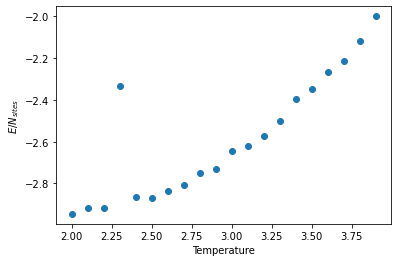

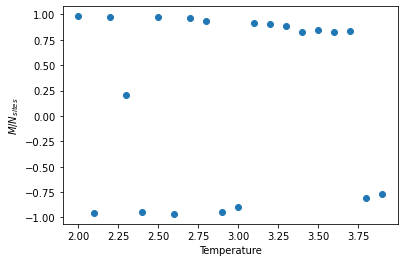

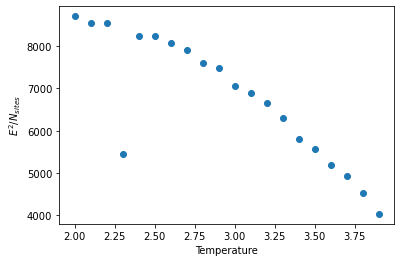

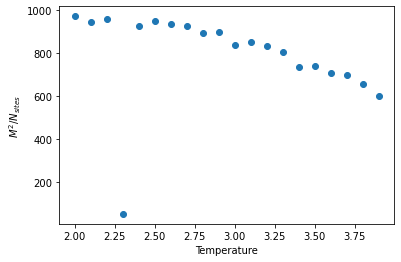

In [44]:
# Specify the size of the ising system
nSide = 10


# Specify the dimension the ising system and set to a state generating function

#d = 2
#state_gen = construct_2d_square_lattice
d = 3
state_gen = construct_3d_cubic_lattice


# Specify the number of frames to run for (make this smaller to run faster!)
nFrames=1000
# Specify the list of temperatures
temperature = np.arange(2, 4, .1)
# Create lists to hold the data outputs
meanE=[]
meanM=[]
meanESq=[]
meanMSq=[]

for T in temperature:
    # Time things so that we can print out something as it's running and not be worried that it's crashed
    start = time.time()
    finalState, ETemp, MTemp = ising(state_gen(nSide), T, nFrames)
    meanE.append(np.mean(ETemp))
    meanM.append(np.mean(MTemp))
    meanESq.append(np.mean(ETemp**2))
    meanMSq.append(np.mean(MTemp**2))
    end = time.time()
    print(f'Temperature {T} took {end-start} seconds to run {nFrames} frames')

plt.figure(0)
plt.plot(temperature, np.array(meanE)/(nSide**d),'o')
plt.xlabel('Temperature')
plt.ylabel('$E/N_{sites}$')

plt.figure(1)
plt.plot(temperature, np.array(meanM)/(nSide**d),'o')
plt.xlabel('Temperature')
plt.ylabel('$M/N_{sites}$')

plt.figure(2)
plt.plot(temperature, np.array(meanESq)/(nSide**d),'o')
plt.xlabel('Temperature')
plt.ylabel('$E^2/N_{sites}$')

plt.figure(3)
plt.plot(temperature, np.array(meanMSq)/(nSide**d),'o')
plt.xlabel('Temperature')
plt.ylabel('$M^2/N_{sites}$')